In [ ]:
# Yottixel's patching algorithm + our pipeline

In [4]:
# (A) System package for OpenSlide tools
!apt-get update -qq && \
 apt-get install -y -qq openslide-tools

# (B) Python packages via pip
#  • Use built-in TensorFlow
#  • Install OpenSlide Python bindings
#  • Install bitarray
#  • Install bitarray-hardbyte from its GitHub source
!pip install --upgrade pip
!pip install openslide-python tensorflow

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package libopenslide0.
(Reading database ... 126284 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-5build1_amd64.deb ...
Unpacking libopenslide0 (3.4.1+dfsg-5build1) ...
Selecting previously unselected package openslide-tools.
Preparing to unpack .../openslide-tools_3.4.1+dfsg-5build1_amd64.deb ...
Unpacking openslide-tools (3.4.1+dfsg-5build1) ...
Setting up libopenslide0 (3.4.1+dfsg-5build1) ...
Setting up openslide-tools (3.4.1+dfsg-5build1) ...
Processing triggers for man-db (2.10.2-1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.8) ...
/sbin/ldconfig.real: /usr/local/lib/libur_adapter_level_zero.so.0 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtcm.so.1 is not a symbolic link

/sbin/ldconfig.re

In [1]:
# gigapath encoder

import os
from pathlib import Path
import torch
import timm
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import subprocess

# insert huggingface token
os.environ['HF_TOKEN'] =  # gitignore
hf_token = os.environ['HF_TOKEN']
assert hf_token, 'HF_TOKEN is not set'

# google cloud authentication
from google.colab import auth
from google.cloud import storage

auth.authenticate_user()
BUCKET_NAME = 'bracs-dataset-bucket'

client = storage.Client()
bucket = client.bucket(BUCKET_NAME)

# download gigapath encoder
import timm

tile_encoder = timm.create_model("hf_hub:prov-gigapath/prov-gigapath", pretrained=True).cuda().eval()
print("Tile Encoder loaded.")
print("Total parameters:", sum(p.numel() for p in tile_encoder.parameters()))

# Image transform
transform = transforms.Compose([
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])





config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Tile Encoder loaded.
Total parameters: 1134953984


In [2]:
# lists slides in a split ['train', 'test', 'val']
def list_slides(split):
    prefixes = [f"BRACS/BRACS_WSI/{split}/Group_AT/",
                f"BRACS/BRACS_WSI/{split}/Group_BT/",
                f"BRACS/BRACS_WSI/{split}/Group_MT/"]
    slides = []
    for pref in prefixes:
        blobs = client.list_blobs(bucket.name, prefix=pref)
        for b in blobs:
            if b.name.lower().endswith(".svs"):
                slides.append(b.name)
    return slides

split = 'train'

len(list_slides(split))

395

In [5]:
import openslide, numpy as np
import cv2
from cv2 import filter2D

%matplotlib inline
import matplotlib.pyplot as plt

# https://github.com/FarhadZanjani/Histopathology-Stain-Color-Normalization/blob/master/ops.py
def RGB2HSD(X):
    eps = np.finfo(float).eps
    X[np.where(X==0.0)] = eps

    OD = -np.log(X / 1.0)
    D  = np.mean(OD,3)
    D[np.where(D==0.0)] = eps

    cx = OD[:,:,:,0] / (D) - 1.0
    cy = (OD[:,:,:,1]-OD[:,:,:,2]) / (np.sqrt(3.0)*D)

    D = np.expand_dims(D,3)
    cx = np.expand_dims(cx,3)
    cy = np.expand_dims(cy,3)

    X_HSD = np.concatenate((D,cx,cy),3)
    return X_HSD


def clean_thumbnail(thumbnail):
    thumbnail_arr = np.asarray(thumbnail)

    # writable thumbnail
    wthumbnail = np.zeros_like(thumbnail_arr)
    wthumbnail[:, :, :] = thumbnail_arr[:, :, :]

    # Remove pen marking here
    # We are skipping this

    # This  section sets regoins with white spectrum as the backgroud regoin
    thumbnail_std = np.std(wthumbnail, axis=2)
    wthumbnail[thumbnail_std<5] = (np.ones((1,3), dtype="uint8")*255)
    thumbnail_HSD = RGB2HSD( np.array([wthumbnail.astype('float32')/255.]) )[0]
    kernel = np.ones((30,30),np.float32)/900
    thumbnail_HSD_mean = cv2.filter2D(thumbnail_HSD[:,:,2],-1,kernel)
    wthumbnail[thumbnail_HSD_mean<0.05] = (np.ones((1,3),dtype="uint8")*255)
    return wthumbnail


# (Placeholder) Your segmentation function: slide → tissue_mask at level=1
def compute_tissue_mask(slide):
    # Returns a NumPy 2D array of 0/1 at level=1
    # You should replace this with your actual mask logic
    lvl = 1
    thumb = slide.get_thumbnail(slide.level_dimensions[lvl])

    arr = np.array(thumb.convert("L"))  # e.g. simple threshold
    tissue_mask = (arr < 200).astype(np.uint8)

    return tissue_mask




In [50]:
import os
import numpy as np
import tqdm
import openslide
from google.colab import auth
from google.cloud import storage
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms

# output directories
os.makedirs('barcodes-train', exist_ok=True)
os.makedirs('barcodes-test', exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# tile_encoder = ...
# transform     = ...

SPLIT  = 'train'
slides = list_slides(SPLIT)

for slide_path in slides[:50]:
    wsi_id            = os.path.basename(slide_path).split('.')[0]
    gcs_embedding_path = f'patch-embeddings/{SPLIT}/{wsi_id}_embeddings.pt'

    # skip already-done
    if client.bucket(bucket.name).blob(gcs_embedding_path).exists():
        print(f'{wsi_id} already processed. Skipping.')
        continue

    print(f'\n----------- Processing WSI {wsi_id} -----------')
    # download & open
    local_svs = f'{wsi_id}.svs'
    client.bucket(bucket.name).blob(slide_path).download_to_filename(local_svs)
    slide = openslide.open_slide(local_svs)

    # 1) tissue mask
    thumbnail = slide.get_thumbnail((500, 500))
    cthumbnail = clean_thumbnail(thumbnail)
    tissue_mask = (cthumbnail.mean(axis=2) != 255)*1.

    # 2) determine patch_size at your desired level
    objective_power = int(slide.properties['openslide.objective-power'])  # e.g. 40
    lvl             = 1
    downsample      = slide.level_downsamples[lvl]                       # e.g. 4
    # virtual 10× patch covering 500µm => raw_patch = (40/20)*1000 / 4 = 500px
    raw_patch       = int((objective_power/20.0)*1000 / downsample)
    patch_size      = raw_patch

    # 3) map mask→WSI scaling
    w0, h0          = slide.dimensions
    mask_h, mask_w  = tissue_mask.shape
    mask_hr         = (mask_h / h0) * patch_size
    mask_wr         = (mask_w / w0) * patch_size

    # 4) slide over WSI and compute coverage
    patches = []
    for i, hi in enumerate(range(0, h0, patch_size)):
        row = []
        for j, wi in enumerate(range(0, w0, patch_size)):
            mi  = int(i * mask_hr)
            mj  = int(j * mask_wr)
            pm  = tissue_mask[mi:mi+int(mask_hr), mj:mj+int(mask_wr)]
            cov = pm.sum() / pm.size
            row.append({
                'loc': [i, j],
                'wsi_loc': [hi, wi],
                'tissue_coverage': cov
            })
        patches.append(row)

    flat       = [p for row in patches for p in row]
    total_cand = len(flat)

    # 5) filter by coverage and extract simple features
    hist_feats = []
    sel        = []
    for p in flat:
        if p['tissue_coverage'] < 0.7:
            continue
        hi, wi      = p['wsi_loc']
        region      = slide.read_region((wi, hi), lvl, (patch_size, patch_size)).convert("RGB")
        arr         = np.array(region) / 255.
        p['rgb_histogram'] = arr.reshape(-1,3).mean(0)
        hist_feats.append(p['rgb_histogram'])
        sel.append(p)

    # if nothing to encode, skip
    if not sel:
        print(f'No tissue-rich patches found ({len(sel)}/{total_cand}). Skipping WSI.')
        os.remove(local_svs)
        continue

    selected = np.stack(hist_feats, axis=0)

    # 6) KMeans & mosaic selection
    K      = 9
    kmeans = KMeans(n_clusters=K).fit(selected)
    for p, lbl in zip(sel, kmeans.labels_):
        p['cluster_lbl'] = int(lbl)

    mosaic = []
    pct    = 5
    for c in range(K):
        group = [p for p in sel if p['cluster_lbl'] == c]
        n     = max(1, int(len(group) * pct/100.))
        if not group:
            continue
        km    = KMeans(n_clusters=n)
        d     = km.fit_transform([p['wsi_loc'] for p in group])
        chosen = set()
        for idx in range(n):
            for s in np.argsort(d[:, idx]):
                if s not in chosen:
                    chosen.add(s)
                    mosaic.append(group[s])
                    break

    # save mosaic in cloud

    rows = len(patches)       # number of patch rows
    cols = len(patches[0])    # number of patch cols
    patch_clusters = np.zeros((rows, cols, 3), dtype=float)
    cmap = plt.cm.get_cmap('hsv', K)  # same K as your kmeans

    # fill in the mosaic patches
    for p in mosaic:
        i, j    = p['loc']
        lbl     = p['cluster_lbl']
        color3  = cmap(lbl)[:3]       # RGB in [0–1]
        patch_clusters[i, j, :] = color3

    # now you can plot & save exactly as before:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].imshow(thumbnail);   axes[0].axis('off')
    axes[1].imshow(patch_clusters); axes[1].axis('off')
    fig.tight_layout(pad=0)

    # save locally
    mosaic_fname = f"{wsi_id}_mosaic.png"
    fig.savefig(mosaic_fname, bbox_inches='tight', pad_inches=0)
    plt.close(fig)

    # upload to GCS
    gcs_mosaic_path = f"mosaics/{SPLIT}/{wsi_id}_mosaic.png"
    client.bucket(bucket.name).blob(gcs_mosaic_path).upload_from_filename(mosaic_fname)
    os.remove(mosaic_fname)
    print(f"→ Uploaded mosaic to gs://{bucket.name}/{gcs_mosaic_path}\n")


    # 7) Encode mosaic with GigaPath in batches
    B          = 20
    batch_imgs = []
    batch_idx  = []
    for mi, p in enumerate(mosaic):
        hi, wi = p['wsi_loc']
        raw     = slide.read_region((wi, hi), lvl, (patch_size, patch_size)).convert("RGB")
        img     = transform(raw).unsqueeze(0).to(device)
        batch_imgs.append(img)
        batch_idx.append(mi)

        if len(batch_imgs) == B:
            inp = torch.cat(batch_imgs, 0)
            with torch.no_grad():
                out = tile_encoder(inp)
            for b, emb in enumerate(out):
                mosaic[batch_idx[b]]['gigapath_embedding'] = emb.cpu().numpy()
            batch_imgs, batch_idx = [], []

    # leftover
    if batch_imgs:
        inp = torch.cat(batch_imgs, 0)
        with torch.no_grad():
            out = tile_encoder(inp)
        for b, emb in enumerate(out):
            mosaic[batch_idx[b]]['gigapath_embedding'] = emb.cpu().numpy()


    # 8) save embeddings
    emb_list   = [p['gigapath_embedding'] for p in mosaic]
    emb_tensor = torch.tensor(emb_list)
    local_pt   = f"{wsi_id}_embeddings.pt"
    torch.save(emb_tensor, local_pt)
    client.bucket(bucket.name).blob(gcs_embedding_path).upload_from_filename(local_pt)


    saved = len(mosaic)
    print(f"→ Saved {saved} patches out of {total_cand} candidates for WSI {wsi_id}.\n")


    # 9) cleanup + summary print
    os.remove(local_svs)
    torch.cuda.empty_cache()
    del slide, patches, mosaic



----------- Processing WSI BRACS_1003728 -----------
No tissue-rich patches found (0/35376). Skipping WSI.

----------- Processing WSI BRACS_1379 -----------


/tmp/ipython-input-50-3654003080.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', K)  # same K as your kmeans


→ Uploaded mosaic to gs://bracs-dataset-bucket/mosaics/train/BRACS_1379_mosaic.png

→ Saved 9 patches out of 31328 candidates for WSI BRACS_1379.


----------- Processing WSI BRACS_1486 -----------


/tmp/ipython-input-50-3654003080.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', K)  # same K as your kmeans


→ Uploaded mosaic to gs://bracs-dataset-bucket/mosaics/train/BRACS_1486_mosaic.png

→ Saved 430 patches out of 52688 candidates for WSI BRACS_1486.


----------- Processing WSI BRACS_1494 -----------


/tmp/ipython-input-50-3654003080.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', K)  # same K as your kmeans


→ Uploaded mosaic to gs://bracs-dataset-bucket/mosaics/train/BRACS_1494_mosaic.png

→ Saved 377 patches out of 34000 candidates for WSI BRACS_1494.


----------- Processing WSI BRACS_1499 -----------


/tmp/ipython-input-50-3654003080.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', K)  # same K as your kmeans


→ Uploaded mosaic to gs://bracs-dataset-bucket/mosaics/train/BRACS_1499_mosaic.png

→ Saved 57 patches out of 10080 candidates for WSI BRACS_1499.


----------- Processing WSI BRACS_1616 -----------


/tmp/ipython-input-50-3654003080.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', K)  # same K as your kmeans


→ Uploaded mosaic to gs://bracs-dataset-bucket/mosaics/train/BRACS_1616_mosaic.png

→ Saved 9 patches out of 30360 candidates for WSI BRACS_1616.


----------- Processing WSI BRACS_1622 -----------


/tmp/ipython-input-50-3654003080.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', K)  # same K as your kmeans


→ Uploaded mosaic to gs://bracs-dataset-bucket/mosaics/train/BRACS_1622_mosaic.png

→ Saved 244 patches out of 26280 candidates for WSI BRACS_1622.


----------- Processing WSI BRACS_1794 -----------


/tmp/ipython-input-50-3654003080.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', K)  # same K as your kmeans


→ Uploaded mosaic to gs://bracs-dataset-bucket/mosaics/train/BRACS_1794_mosaic.png

→ Saved 705 patches out of 39128 candidates for WSI BRACS_1794.


----------- Processing WSI BRACS_1795 -----------


/tmp/ipython-input-50-3654003080.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', K)  # same K as your kmeans


→ Uploaded mosaic to gs://bracs-dataset-bucket/mosaics/train/BRACS_1795_mosaic.png

→ Saved 601 patches out of 27664 candidates for WSI BRACS_1795.


----------- Processing WSI BRACS_1808 -----------


/tmp/ipython-input-50-3654003080.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', K)  # same K as your kmeans


→ Uploaded mosaic to gs://bracs-dataset-bucket/mosaics/train/BRACS_1808_mosaic.png

→ Saved 612 patches out of 35424 candidates for WSI BRACS_1808.


----------- Processing WSI BRACS_1860 -----------


/tmp/ipython-input-50-3654003080.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', K)  # same K as your kmeans


→ Uploaded mosaic to gs://bracs-dataset-bucket/mosaics/train/BRACS_1860_mosaic.png

→ Saved 575 patches out of 30832 candidates for WSI BRACS_1860.


----------- Processing WSI BRACS_1861 -----------


/tmp/ipython-input-50-3654003080.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', K)  # same K as your kmeans


→ Uploaded mosaic to gs://bracs-dataset-bucket/mosaics/train/BRACS_1861_mosaic.png

→ Saved 765 patches out of 48984 candidates for WSI BRACS_1861.


----------- Processing WSI BRACS_1863 -----------


/tmp/ipython-input-50-3654003080.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', K)  # same K as your kmeans


→ Uploaded mosaic to gs://bracs-dataset-bucket/mosaics/train/BRACS_1863_mosaic.png

→ Saved 775 patches out of 39160 candidates for WSI BRACS_1863.


----------- Processing WSI BRACS_1877 -----------


/tmp/ipython-input-50-3654003080.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', K)  # same K as your kmeans


→ Uploaded mosaic to gs://bracs-dataset-bucket/mosaics/train/BRACS_1877_mosaic.png

→ Saved 427 patches out of 21920 candidates for WSI BRACS_1877.


----------- Processing WSI BRACS_1882 -----------


/tmp/ipython-input-50-3654003080.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', K)  # same K as your kmeans


→ Uploaded mosaic to gs://bracs-dataset-bucket/mosaics/train/BRACS_1882_mosaic.png

→ Saved 205 patches out of 16764 candidates for WSI BRACS_1882.


----------- Processing WSI BRACS_1899 -----------


/tmp/ipython-input-50-3654003080.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', K)  # same K as your kmeans


→ Uploaded mosaic to gs://bracs-dataset-bucket/mosaics/train/BRACS_1899_mosaic.png

→ Saved 585 patches out of 25116 candidates for WSI BRACS_1899.


----------- Processing WSI BRACS_1911 -----------


/tmp/ipython-input-50-3654003080.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', K)  # same K as your kmeans


→ Uploaded mosaic to gs://bracs-dataset-bucket/mosaics/train/BRACS_1911_mosaic.png

→ Saved 255 patches out of 23584 candidates for WSI BRACS_1911.


----------- Processing WSI BRACS_1912 -----------


/tmp/ipython-input-50-3654003080.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', K)  # same K as your kmeans


→ Uploaded mosaic to gs://bracs-dataset-bucket/mosaics/train/BRACS_1912_mosaic.png

→ Saved 363 patches out of 51976 candidates for WSI BRACS_1912.


----------- Processing WSI BRACS_1913 -----------


/tmp/ipython-input-50-3654003080.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', K)  # same K as your kmeans


→ Uploaded mosaic to gs://bracs-dataset-bucket/mosaics/train/BRACS_1913_mosaic.png

→ Saved 794 patches out of 35420 candidates for WSI BRACS_1913.


----------- Processing WSI BRACS_1915 -----------


/tmp/ipython-input-50-3654003080.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', K)  # same K as your kmeans


→ Uploaded mosaic to gs://bracs-dataset-bucket/mosaics/train/BRACS_1915_mosaic.png

→ Saved 694 patches out of 35828 candidates for WSI BRACS_1915.


----------- Processing WSI BRACS_1922 -----------


/tmp/ipython-input-50-3654003080.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', K)  # same K as your kmeans


→ Uploaded mosaic to gs://bracs-dataset-bucket/mosaics/train/BRACS_1922_mosaic.png

→ Saved 619 patches out of 43432 candidates for WSI BRACS_1922.


----------- Processing WSI BRACS_1925 -----------


/tmp/ipython-input-50-3654003080.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', K)  # same K as your kmeans


→ Uploaded mosaic to gs://bracs-dataset-bucket/mosaics/train/BRACS_1925_mosaic.png

→ Saved 429 patches out of 26864 candidates for WSI BRACS_1925.


----------- Processing WSI BRACS_1932 -----------


/tmp/ipython-input-50-3654003080.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', K)  # same K as your kmeans


→ Uploaded mosaic to gs://bracs-dataset-bucket/mosaics/train/BRACS_1932_mosaic.png

→ Saved 315 patches out of 27768 candidates for WSI BRACS_1932.


----------- Processing WSI BRACS_1933 -----------


/tmp/ipython-input-50-3654003080.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', K)  # same K as your kmeans


→ Uploaded mosaic to gs://bracs-dataset-bucket/mosaics/train/BRACS_1933_mosaic.png

→ Saved 649 patches out of 55728 candidates for WSI BRACS_1933.


----------- Processing WSI BRACS_1934 -----------


/tmp/ipython-input-50-3654003080.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', K)  # same K as your kmeans


→ Uploaded mosaic to gs://bracs-dataset-bucket/mosaics/train/BRACS_1934_mosaic.png

→ Saved 497 patches out of 56248 candidates for WSI BRACS_1934.


----------- Processing WSI BRACS_1969 -----------


/tmp/ipython-input-50-3654003080.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', K)  # same K as your kmeans


→ Uploaded mosaic to gs://bracs-dataset-bucket/mosaics/train/BRACS_1969_mosaic.png

→ Saved 532 patches out of 35392 candidates for WSI BRACS_1969.


----------- Processing WSI BRACS_1987 -----------


/tmp/ipython-input-50-3654003080.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', K)  # same K as your kmeans


→ Uploaded mosaic to gs://bracs-dataset-bucket/mosaics/train/BRACS_1987_mosaic.png

→ Saved 658 patches out of 22532 candidates for WSI BRACS_1987.


----------- Processing WSI BRACS_3318 -----------


/tmp/ipython-input-50-3654003080.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', K)  # same K as your kmeans


→ Uploaded mosaic to gs://bracs-dataset-bucket/mosaics/train/BRACS_3318_mosaic.png

→ Saved 310 patches out of 34560 candidates for WSI BRACS_3318.


----------- Processing WSI BRACS_1003693 -----------


/tmp/ipython-input-50-3654003080.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', K)  # same K as your kmeans


→ Uploaded mosaic to gs://bracs-dataset-bucket/mosaics/train/BRACS_1003693_mosaic.png

→ Saved 711 patches out of 48657 candidates for WSI BRACS_1003693.


----------- Processing WSI BRACS_1239 -----------


/tmp/ipython-input-50-3654003080.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', K)  # same K as your kmeans


→ Uploaded mosaic to gs://bracs-dataset-bucket/mosaics/train/BRACS_1239_mosaic.png

→ Saved 1124 patches out of 48238 candidates for WSI BRACS_1239.


----------- Processing WSI BRACS_1250 -----------


/tmp/ipython-input-50-3654003080.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', K)  # same K as your kmeans


→ Uploaded mosaic to gs://bracs-dataset-bucket/mosaics/train/BRACS_1250_mosaic.png

→ Saved 590 patches out of 26832 candidates for WSI BRACS_1250.


----------- Processing WSI BRACS_1257 -----------


/tmp/ipython-input-50-3654003080.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', K)  # same K as your kmeans


→ Uploaded mosaic to gs://bracs-dataset-bucket/mosaics/train/BRACS_1257_mosaic.png

→ Saved 1240 patches out of 40016 candidates for WSI BRACS_1257.


----------- Processing WSI BRACS_1319 -----------


/tmp/ipython-input-50-3654003080.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', K)  # same K as your kmeans


→ Uploaded mosaic to gs://bracs-dataset-bucket/mosaics/train/BRACS_1319_mosaic.png

→ Saved 698 patches out of 34112 candidates for WSI BRACS_1319.


----------- Processing WSI BRACS_1506 -----------


/tmp/ipython-input-50-3654003080.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', K)  # same K as your kmeans


→ Uploaded mosaic to gs://bracs-dataset-bucket/mosaics/train/BRACS_1506_mosaic.png

→ Saved 377 patches out of 43432 candidates for WSI BRACS_1506.


----------- Processing WSI BRACS_1510 -----------


/tmp/ipython-input-50-3654003080.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', K)  # same K as your kmeans


→ Uploaded mosaic to gs://bracs-dataset-bucket/mosaics/train/BRACS_1510_mosaic.png

→ Saved 290 patches out of 27888 candidates for WSI BRACS_1510.


----------- Processing WSI BRACS_1773 -----------


/tmp/ipython-input-50-3654003080.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', K)  # same K as your kmeans


→ Uploaded mosaic to gs://bracs-dataset-bucket/mosaics/train/BRACS_1773_mosaic.png

→ Saved 691 patches out of 34556 candidates for WSI BRACS_1773.


----------- Processing WSI BRACS_1774 -----------


/tmp/ipython-input-50-3654003080.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', K)  # same K as your kmeans


→ Uploaded mosaic to gs://bracs-dataset-bucket/mosaics/train/BRACS_1774_mosaic.png

→ Saved 262 patches out of 12948 candidates for WSI BRACS_1774.


----------- Processing WSI BRACS_1775 -----------


/tmp/ipython-input-50-3654003080.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', K)  # same K as your kmeans


→ Uploaded mosaic to gs://bracs-dataset-bucket/mosaics/train/BRACS_1775_mosaic.png

→ Saved 541 patches out of 31692 candidates for WSI BRACS_1775.


----------- Processing WSI BRACS_1777 -----------


/tmp/ipython-input-50-3654003080.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', K)  # same K as your kmeans


→ Uploaded mosaic to gs://bracs-dataset-bucket/mosaics/train/BRACS_1777_mosaic.png

→ Saved 927 patches out of 38448 candidates for WSI BRACS_1777.


----------- Processing WSI BRACS_1778 -----------


/tmp/ipython-input-50-3654003080.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', K)  # same K as your kmeans


→ Uploaded mosaic to gs://bracs-dataset-bucket/mosaics/train/BRACS_1778_mosaic.png

→ Saved 318 patches out of 20000 candidates for WSI BRACS_1778.


----------- Processing WSI BRACS_1788 -----------


/tmp/ipython-input-50-3654003080.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', K)  # same K as your kmeans


→ Uploaded mosaic to gs://bracs-dataset-bucket/mosaics/train/BRACS_1788_mosaic.png

→ Saved 333 patches out of 30600 candidates for WSI BRACS_1788.


----------- Processing WSI BRACS_1815 -----------


/tmp/ipython-input-50-3654003080.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', K)  # same K as your kmeans


→ Uploaded mosaic to gs://bracs-dataset-bucket/mosaics/train/BRACS_1815_mosaic.png

→ Saved 664 patches out of 35360 candidates for WSI BRACS_1815.


----------- Processing WSI BRACS_1838 -----------


/tmp/ipython-input-50-3654003080.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', K)  # same K as your kmeans


→ Uploaded mosaic to gs://bracs-dataset-bucket/mosaics/train/BRACS_1838_mosaic.png

→ Saved 714 patches out of 39872 candidates for WSI BRACS_1838.


----------- Processing WSI BRACS_1857 -----------


/tmp/ipython-input-50-3654003080.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', K)  # same K as your kmeans


→ Uploaded mosaic to gs://bracs-dataset-bucket/mosaics/train/BRACS_1857_mosaic.png

→ Saved 371 patches out of 36112 candidates for WSI BRACS_1857.


----------- Processing WSI BRACS_1858 -----------


/tmp/ipython-input-50-3654003080.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', K)  # same K as your kmeans


→ Uploaded mosaic to gs://bracs-dataset-bucket/mosaics/train/BRACS_1858_mosaic.png

→ Saved 1164 patches out of 46096 candidates for WSI BRACS_1858.


----------- Processing WSI BRACS_1865 -----------


/tmp/ipython-input-50-3654003080.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', K)  # same K as your kmeans


→ Uploaded mosaic to gs://bracs-dataset-bucket/mosaics/train/BRACS_1865_mosaic.png

→ Saved 845 patches out of 29516 candidates for WSI BRACS_1865.


----------- Processing WSI BRACS_1871 -----------


/tmp/ipython-input-50-3654003080.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', K)  # same K as your kmeans


→ Uploaded mosaic to gs://bracs-dataset-bucket/mosaics/train/BRACS_1871_mosaic.png

→ Saved 461 patches out of 30444 candidates for WSI BRACS_1871.


----------- Processing WSI BRACS_1916 -----------


/tmp/ipython-input-50-3654003080.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', K)  # same K as your kmeans


→ Uploaded mosaic to gs://bracs-dataset-bucket/mosaics/train/BRACS_1916_mosaic.png

→ Saved 344 patches out of 30000 candidates for WSI BRACS_1916.


----------- Processing WSI BRACS_1926 -----------


/tmp/ipython-input-50-3654003080.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', K)  # same K as your kmeans


→ Uploaded mosaic to gs://bracs-dataset-bucket/mosaics/train/BRACS_1926_mosaic.png

→ Saved 494 patches out of 25600 candidates for WSI BRACS_1926.


----------- Processing WSI BRACS_1968 -----------


/tmp/ipython-input-50-3654003080.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', K)  # same K as your kmeans


→ Uploaded mosaic to gs://bracs-dataset-bucket/mosaics/train/BRACS_1968_mosaic.png

→ Saved 435 patches out of 25160 candidates for WSI BRACS_1968.



In [6]:
import io
import torch
from google.colab import auth
from google.cloud import storage

# 1. Authenticate & init GCS client
auth.authenticate_user()
client = storage.Client()

bucket_name = "bracs-dataset-bucket"
prefix = "patch-embeddings/train/"

# 2. List all .pt blobs under the prefix
bucket = client.bucket(bucket_name)
blobs = list(bucket.list_blobs(prefix=prefix))

print(f"{'Blob name':70s}  {'#patches':>8s}  {'emb_dim':>8s}")
print("-"*90)

for blob in blobs:
    if not blob.name.endswith(".pt"):
        continue

    # 3. Download into memory and load
    data_bytes = blob.download_as_bytes()
    tensor = torch.load(io.BytesIO(data_bytes), map_location="cpu")

    # 4. If you ever wrap embeddings in a dict, adjust here:
    if isinstance(tensor, dict) and "embeddings" in tensor:
        tensor = tensor["embeddings"]

    # 5. Now tensor should be (num_patches, emb_dim)
    num_patches, emb_dim = tensor.shape
    print(f"{blob.name:70s}  {num_patches:8d}  {emb_dim:8d}")


Blob name                                                               #patches   emb_dim
------------------------------------------------------------------------------------------
patch-embeddings/train/BRACS_1003693_embeddings.pt                          1356      1536
patch-embeddings/train/BRACS_1003728_embeddings.pt                             9      1536
patch-embeddings/train/BRACS_1239_embeddings.pt                             2444      1536
patch-embeddings/train/BRACS_1250_embeddings.pt                             1944      1536
patch-embeddings/train/BRACS_1257_embeddings.pt                             4134      1536
patch-embeddings/train/BRACS_1319_embeddings.pt                             2157      1536
patch-embeddings/train/BRACS_1379_embeddings.pt                               13      1536
patch-embeddings/train/BRACS_1486_embeddings.pt                              451      1536
patch-embeddings/train/BRACS_1494_embeddings.pt                              657      1536

## Sanity Check

In [42]:
SLIDE_PATH = "BRACS/BRACS_WSI/train/Group_AT/Type_ADH/BRACS_1379.svs"

blob = bucket.blob(SLIDE_PATH)

local_slide = SLIDE_PATH.split("/")[-1]
print(f"Downloading {SLIDE_PATH} to ./{local_slide} …")
blob.download_to_filename(local_slide)
print("Download complete.")

# 6. Open with OpenSlide
slide = openslide.open_slide(local_slide)

import matplotlib.pyplot as plt
%matplotlib inline

thumbnail = slide.get_thumbnail((500, 500))
cthumbnail = clean_thumbnail(thumbnail)
tissue_mask = (cthumbnail.mean(axis=2) != 255)*1.

tissue_mask2 = compute_tissue_mask(slide)






Download complete.


(np.float64(-0.5), np.float64(21911.5), np.float64(22182.5), np.float64(-0.5))

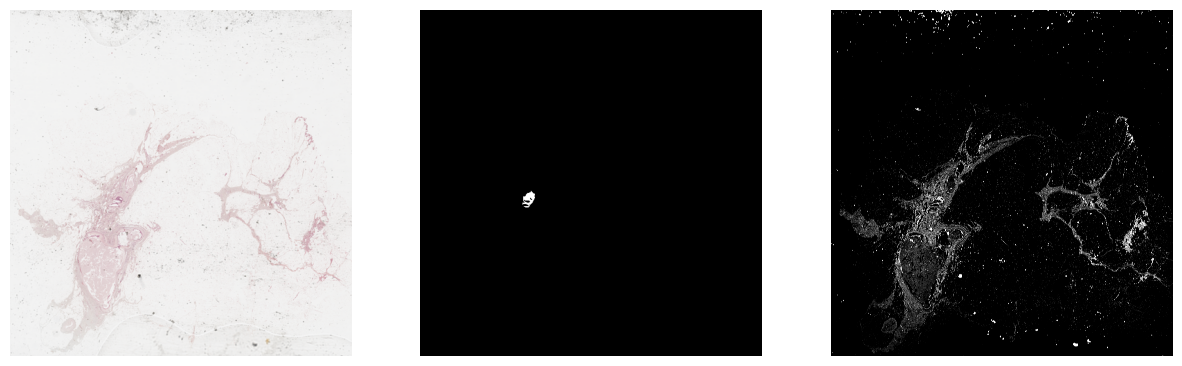

In [43]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(thumbnail)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(tissue_mask, cmap='Greys_r')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(tissue_mask2, cmap='Greys_r')
plt.axis('off')

In [44]:
import numpy as np

# --- 1. Compute patch dimensions for 40× slides ---
objective_power = int(slide.properties['openslide.objective-power'])  # = 40

# Always read at level=1 (≈10×), then downscale by ½
lvl = 1
downsample = slide.level_downsamples[lvl]                  # ~4.0 for 40→10
raw_patch_size = int((objective_power/20.0) * 1000 / downsample)  # = 500 px
patch_size = raw_patch_size                           # = 500 px

# --- 2. Build tissue‐mask ratios exactly as Yottixel does ---
w0, h0 = slide.dimensions
mask_h, mask_w = tissue_mask.shape

mask_hratio = (mask_h / h0) * patch_size
mask_wratio = (mask_w / w0) * patch_size

# --- 3. Iterate over the WSI in strides of patch_size ---
patches = []

for i, hi in enumerate(range(0, h0, patch_size)):
    _patches = []
    for j, wi in enumerate(range(0, w0, patch_size)):
        # Map patch grid → mask grid
        mi = int(i * mask_hratio)
        mj = int(j * mask_wratio)

        # Crop out the corresponding region of the segmentation mask
        patch_mask = tissue_mask[
            mi : mi + int(mask_hratio),
            mj : mj + int(mask_wratio)
        ]

        # Compute tissue coverage
        tissue_coverage = np.count_nonzero(patch_mask) / patch_mask.size

        _patches.append({
            'loc':            [i, j],
            'wsi_loc':        [int(hi), int(wi)],
            'tissue_coverage': tissue_coverage
        })
    patches.append(_patches)

# `patches` has the same structure as in Yottixel,
# but using 500x500-pixel patches at 10x level.




In [45]:
print(f'rows: {len(patches)}')
print(f'cols: {len(patches[0])}')

total_patch = len(patches) * len(patches[0])
print(f'total patch: {total_patch}')

import tqdm

objective_power = int(slide.properties['openslide.objective-power'])  # = 40
lvl = 1
downsample = slide.level_downsamples[lvl]                             # ≈4.0 for 40→10

# for patch to be considered it should have this much tissue area
tissue_threshold = 0.7

flat_patches = np.ravel(patches)
for patch in tqdm.tqdm(flat_patches):

    # ignore patches with less tissue coverage
    if patch['tissue_coverage'] < tissue_threshold:
        continue

    # this loc is at the objective power
    h, w = patch['wsi_loc']

    # we will go obe level lower, i.e. (objective power / 4)
    # we still need patches at 5x of size 250x250
    # this logic can be modified and may not work properly for images of lower objective power < 20 or greater than 40                # ≈4.0 for 40→10

    # “Raw” patch size at 10×: (40/20)*1000 = 2000px at level 0 →
    # divide by downsample to get level 1 pixels:
    patch_size_10x = int((objective_power/20.0)*1000 / downsample)        # = 500px

    # 2. Halve it to get 5× patch size:
    patch_size_5x = patch_size_10x // 2

    patch_region = slide.read_region((w, h), 1, (patch_size_5x, patch_size_5x)).convert('RGB')

    if patch_region.size[0] != 250:
        patch_region = patch_region.resize((250, 250))

    histogram = (np.array(patch_region)/255.).reshape((250*250, 3)).mean(axis=0)
    patch['rgb_histogram'] = histogram


rows: 178
cols: 176
total patch: 31328


100%|██████████| 31328/31328 [00:00<00:00, 106903.85it/s]


In [46]:
from sklearn.cluster import KMeans
selected_patches_flags = [patch['tissue_coverage'] >= tissue_threshold for patch in flat_patches]
selected_patches = flat_patches[selected_patches_flags]

print(f'selected patches : {len(selected_patches)}')
t = len(selected_patches)*0.05
print(t)

kmeans_clusters = 9
kmeans = KMeans(n_clusters = kmeans_clusters)
features = np.array([entry['rgb_histogram'] for entry in selected_patches])

kmeans.fit(features)

selected patches : 24
1.2000000000000002


KMeans(n_clusters=9)

/tmp/ipython-input-47-341723741.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', kmeans_clusters)


(np.float64(-0.5), np.float64(175.5), np.float64(177.5), np.float64(-0.5))

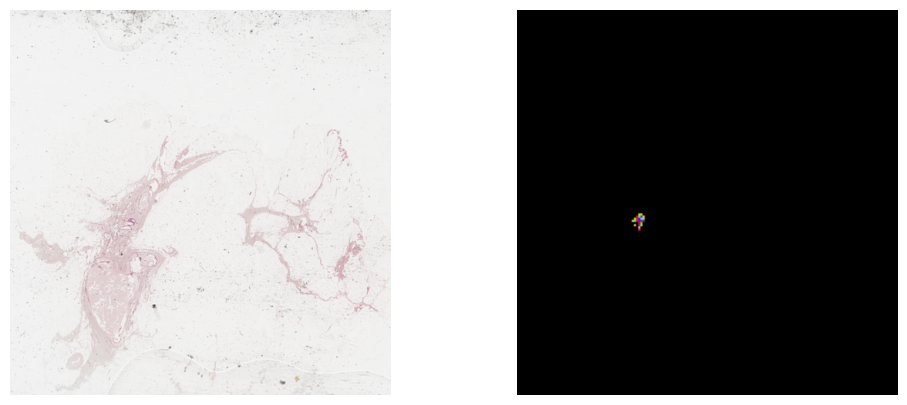

In [47]:
import matplotlib.pyplot as plt
cmap = plt.cm.get_cmap('hsv', kmeans_clusters)

patch_clusters = np.zeros(np.array(patches).shape+(3,))


for patch, label in zip(selected_patches, kmeans.labels_):
    patch_clusters[patch['loc'][0], patch['loc'][1], :] = cmap(label)[:3]
    patch['cluster_lbl'] = label

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(thumbnail)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(patch_clusters)
plt.axis('off')

In [48]:
# Selecting Mosaic

# Another hyperparameter of Yottixel
# Yottixel has been tested with 5, 10, and 15 with 15 performing most optimally
percentage_selected = 5

mosaic = []

for i in range(kmeans_clusters):
    cluster_patches = selected_patches[kmeans.labels_ == i]
    n_selected = max(1, int(len(cluster_patches)*percentage_selected/100.))

    km = KMeans(n_clusters=n_selected)
    loc_features = [patch['wsi_loc'] for patch in cluster_patches]
    ds = km.fit_transform(loc_features)

    c_selected_idx = []
    for idx in range(n_selected):
        sorted_idx = np.argsort(ds[:, idx])

        for sidx in sorted_idx:
            if sidx not in c_selected_idx:
                c_selected_idx.append(sidx)
                mosaic.append(cluster_patches[sidx])
                break
len(mosaic)

9

(np.float64(-0.5), np.float64(175.5), np.float64(177.5), np.float64(-0.5))

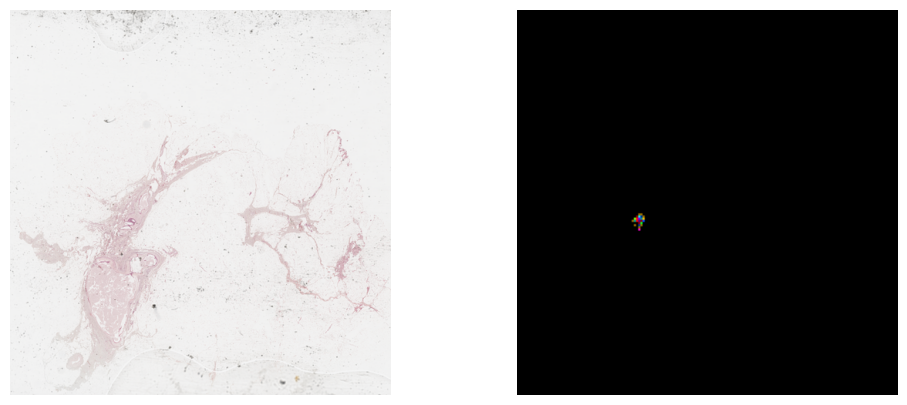

In [49]:
patch_clusters = np.zeros(np.array(patches).shape+(3,))

for patch in selected_patches:
    patch_clusters[patch['loc'][0], patch['loc'][1], :] = np.array(cmap(patch['cluster_lbl'])[:3])*0.6
for patch in mosaic:
    patch_clusters[patch['loc'][0], patch['loc'][1], :] = cmap(patch['cluster_lbl'])[:3]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(thumbnail)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(patch_clusters)
plt.axis('off')